In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, nm, mm, np
from diffractio.scalar_fields_X import Scalar_field_X
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from scipy.constants import m_e, e, h
from numba import njit, prange
%matplotlib ipympl

Functions to calculate diffraction pattern after slit using Rayleigh Sommerfeld method, and Monte Carlo Integration method. 

In [2]:
def vector_rejection(point, orig, norm):
    v = point - orig
    dist = np.dot(v, norm)
    return -(point - dist*norm)

@njit()
def scalar_rejection(point, orig, norm):
    v = orig - point
    return np.dot(v, norm)


In [3]:
def diffractio_rs_aperture_1D(x0, 
                           z_prop,
                           aperture_width, 
                           wavelength,
                           draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_X(x0, wavelength)
    t0.slit(x0=0, size=aperture_width*um)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw()
        t0.draw()

    return u2

def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.slit(x0=0, size=aperture_width*um, angle=0)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2

# @njit(parallel=True)
def monte_carlo_rs_aperture(num_rays, 
                            final_image,
                            sample_yx_indices,
                            sample_yx_coords,
                            det_yx_indices,
                            det_zyx_coords,
                            sample_phase_shifts,
                            z_prop,
                            wavelength,
                            planewaveapprox):
    
    len_sample_indices = sample_yx_indices.shape[0]
    len_det_indices = det_yx_indices.shape[0]
    
    for _ in range(num_rays):

        random_sample_coord_idx = np.random.randint(len_sample_indices)
        random_detector_coord_idx = np.random.randint(len_det_indices)
        
        sample_phase_shift = sample_phase_shifts[random_sample_coord_idx]
        random_sample_coord_yx = sample_yx_coords[random_sample_coord_idx]
        
        random_detector_coord_zyx = det_zyx_coords[random_detector_coord_idx]

        x_dist = random_sample_coord_yx[1] - random_detector_coord_zyx[2]
        y_dist = random_sample_coord_yx[0] - random_detector_coord_zyx[1]
        distance = np.sqrt(x_dist ** 2 + y_dist ** 2 + z_prop ** 2)

        ray_dir_cosine = z_prop / distance

        # See Chapter 2 of Marco Mout thesis for reasoning behind wi_ws: I think it comes from 
        # the Rayleigh Sommerfeld Diffraction Integral obliquity factor
        wi_ws = np.sqrt(1 / ray_dir_cosine) * ray_dir_cosine 

        if planewaveapprox:
            
            # Get ray vector and make it a unit vector
            ray_v = np.array([z_prop, y_dist, x_dist])
            ray_unit_v = ray_v/np.linalg.norm(ray_v)
            
            # Get vector pointing from detector pixel coordinates to where the ray has hit. 
            v = random_detector_coord_zyx - det_zyx_coords
            
            # Dot product v with the direction vector of the ray, to find the component of the vector v in the direction of the ray
            # This tells us the distance from the detector pixel to the tilted plane normal to the direction of the ray, which tells us the path length
            # difference we must apply to calculate the phase of the plane wave at each pixel on the detector. 
            signed_length_wavefront_to_px = np.dot(v, ray_unit_v)
            
            distance_phases = np.exp(1j * (distance + signed_length_wavefront_to_px) * ((2 * np.pi) / wavelength))
            sample_phase = np.exp(1j * (sample_phase_shift))
            final_image +=  wi_ws * distance_phases * sample_phase
        else:
            distance_phase = np.exp(1j * distance * ((2 * np.pi) / wavelength))
            sample_phase = np.exp(1j * (sample_phase_shift))
            
            final_image[random_detector_coord_idx] +=  wi_ws * distance_phase * sample_phase * (1 / distance)

    return final_image



@njit(parallel=True)
def monte_carlo_rs_atom(num_rays, 
                        num_px,
                        z_prop,
                        x0,
                        potential, 
                        wavelength,
                        sigma):
    
    final_image = np.zeros(num_px, dtype = np.complex128)
    pixels_detector = np.arange(0, len(x0), 1)

    y0 = np.zeros(len(pixels_detector), dtype = np.float64)
    bin_coords_yx = np.vstack((y0, x0)).T

    for _ in prange(num_rays):

        potential_idx = np.random.choice(pixels_detector)
        det_idx = np.random.choice(pixels_detector)

        potential_val = potential[potential_idx][0]
        potential_x_coordinate = x0[potential_idx]
        detector_x_coordinate = x0[det_idx]

        x_dist = potential_x_coordinate - detector_x_coordinate
        distance = np.sqrt(x_dist ** 2 + z_prop ** 2)

        ray_v = np.array([z_prop, x_dist])
        ray_unit_v = ray_v/np.linalg.norm(ray_v)

        det_coord = np.array([0, detector_x_coordinate])
        signed_length_wavefront_to_px_v = scalar_rejection(bin_coords_yx, det_coord, ray_unit_v)
        distance_phase_shift = np.exp((distance + signed_length_wavefront_to_px_v) * ((2 * np.pi) / wavelength) * 1j)
        sample_phase_shift = np.exp(1j * (potential_val * sigma))

        ray_dir_cosine = z_prop / distance

        ws = 1 * ray_dir_cosine
        wi = np.sqrt(1 / ray_dir_cosine)

        final_image += wi * ws * (distance_phase_shift * sample_phase_shift)


    return final_image


Set up initial conditions

In [4]:
aperture_diameter = 200 * um
detector_width_x = 1000 * um
detector_width_y = 0 * um

num_px_x = 4096
num_px_y = 1
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices[np.sqrt(det_yx_coords[:, 0]**2 + det_yx_coords[:, 1]**2) < aperture_diameter/2]
sample_yx_coords = det_yx_coords[np.sqrt(det_yx_coords[:, 0]**2 + det_yx_coords[:, 1]**2) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

z_prop = 5 * mm
wavelength = 0.638 * um

print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

Fresnel Number =  1.2539184952978056e-05


Show initial field, aperture, and calculate the diffracted field some distance z after the aperture using the Hankel Transform in diffractio. 

Good result: factor 13.05


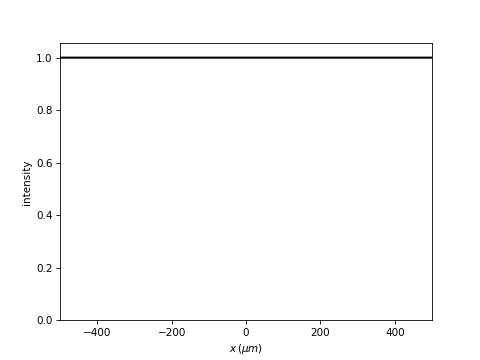

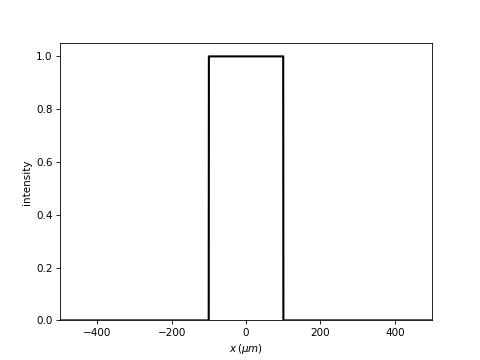

In [5]:
u2 = diffractio_rs_aperture_1D(x0=det_yx_coords[:, 1], 
                            z_prop=z_prop, 
                            aperture_width=aperture_diameter, 
                            wavelength=wavelength, 
                            draw_inputs=True)

Explain how monte carlo method works: The Huygens Fresnel Principle states that every point on a wavefront is itself the source of spherical wavelets (See image below). The Rayleigh Sommerfeld diffraction integral is a mathematical description of this principle. We can exploit the Huygens Fresnel principle in regions where geometrical optics breaks down (such as at an aperture or in a thin sample) to continue to propagate rays which also carry information about an aperture or sample. By sampling random directions on each spherical wavefront at a "diffracting surface" and propagating rays forward we can perform a "monte carlo integration" solution to the rayleigh sommerfeld diffraction integral, which allows us to circumvent the use of Fourier methods to solve this diffraction integral, enabling us to more easily integrate wavefront propagation in the context of real microscope components that span large distances. The drawback of this method is that many rays are required, but with modern processing power we may be able to mitigate this drawback.

Below: Image of Huygens Fresnel Principle.

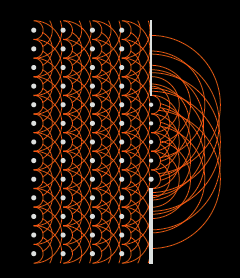


Solve RS diffraction integral with monte carlo method and plot results against diffractio with single rays. 

In [6]:
num_rays=int(1e9)
planewaveapprox=False

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image = monte_carlo_rs_aperture(num_rays, 
                                      final_image,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

Solve RS diffraction integral with monte carlo method and plot results against diffractio with plane wave approximation.

In [7]:
planewaveapprox=True
num_rays=int(1e6)
final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image_pw = monte_carlo_rs_aperture(num_rays, 
                                      final_image_pw,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

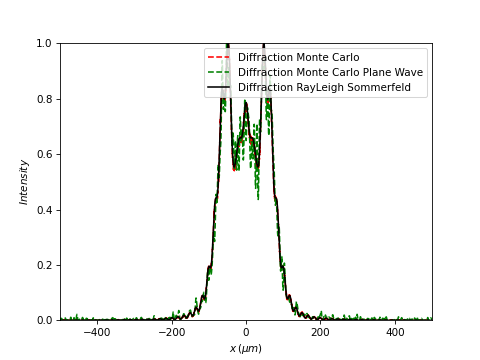

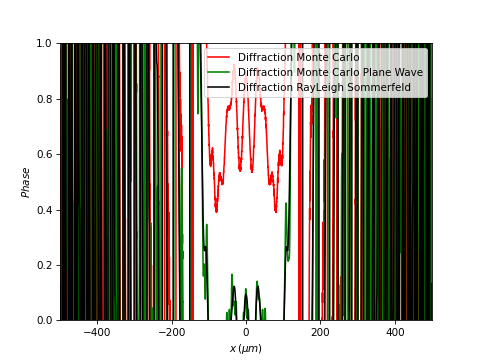

In [8]:

fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[:, 1], np.abs(final_image)**2/np.max(np.abs(final_image)**2), '--r', label='Diffraction Monte Carlo')
ax.plot(det_yx_coords[:, 1], np.abs(final_image_pw)**2/np.max(np.abs(final_image_pw)**2), '--g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[:, 1], np.abs(u2.u)**2/np.max(np.abs(u2.u)**2), '-k', label='Diffraction RayLeigh Sommerfeld')
plt.legend()

fig, ax = plt.subplots()
ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[:, 1], np.angle(final_image), 'r', label='Diffraction Monte Carlo')
ax.plot(det_yx_coords[:, 1], np.angle(final_image_pw), 'g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[:, 1], np.angle(u2.u), '-k', label='Diffraction RayLeigh Sommerfeld')

plt.legend()


In [9]:
aperture_diameter = 200 * um
detector_width_x = 1000 * um
detector_width_y = 1000 * um

num_px_x = 512
num_px_y = 512
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

y_indices, x_indices = np.meshgrid(np.arange(num_px_y), np.arange(num_px_x), indexing='ij')

# Combine the coordinates into a single array of (y, x) pairs
det_yx_indices = np.vstack([y_indices.ravel(), x_indices.ravel()]).T
num_pixels = int(num_px_x*num_px_y)

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
sample_yx_coords = det_yx_coords[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

z_prop = 5 * mm
wavelength = 0.638 * um

print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

Fresnel Number =  1.2539184952978056e-05


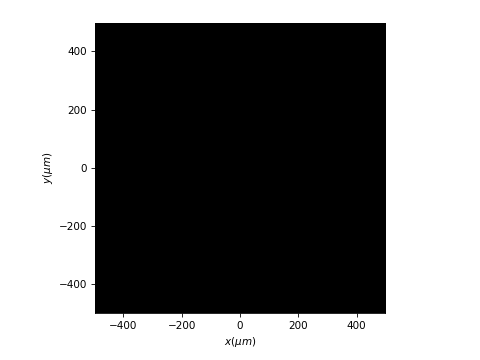

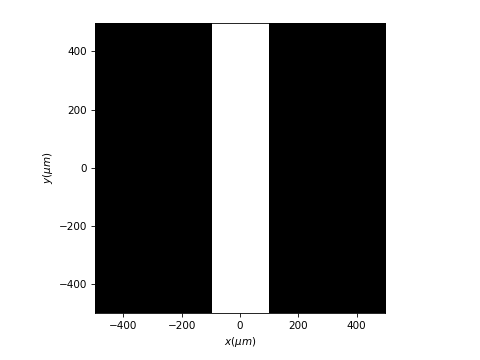

In [10]:
u2 = diffractio_rs_aperture_2D(x0=det_zyx_coords[:num_px_x, 2], 
                               y0=det_zyx_coords[:num_px_y, 2],
                               z_prop=z_prop, 
                               aperture_width=aperture_diameter, 
                               wavelength=wavelength, 
                               draw_inputs=True)

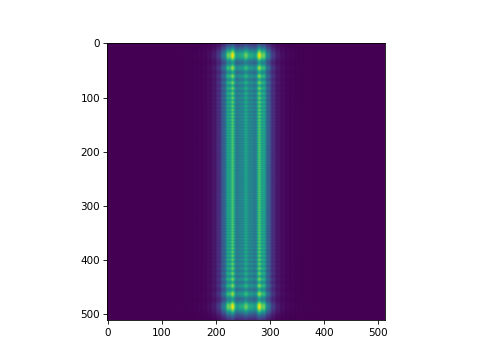

In [11]:
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Diffraction RayLeigh Sommerfeld')

In [12]:
num_rays=int(1e9)
planewaveapprox=False

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image = monte_carlo_rs_aperture(num_rays, 
                                      final_image,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

final_image = final_image.reshape(num_px_y, num_px_x)

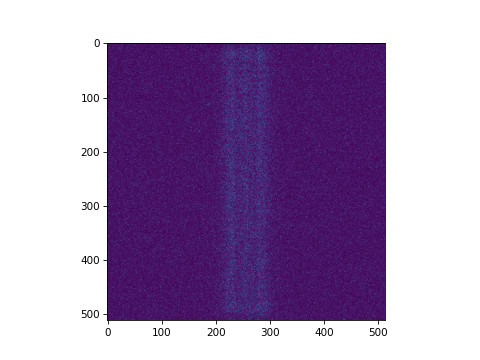

In [13]:
fig, ax = plt.subplots()
ax.imshow((np.abs(final_image) ** 2)/np.max(np.abs(final_image) ** 2), label='Diffraction Monte Carlo')

In [14]:
num_rays=int(1e5)
planewaveapprox=True

final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image_pw = monte_carlo_rs_aperture(num_rays, 
                                         final_image_pw,
                                         sample_yx_indices,
                                         sample_yx_coords,
                                         det_yx_indices,
                                         det_zyx_coords,
                                         aperture_phase_shifts,
                                         z_prop,
                                         wavelength,
                                         planewaveapprox)

final_image_pw = final_image_pw.reshape(num_px_y, num_px_x)

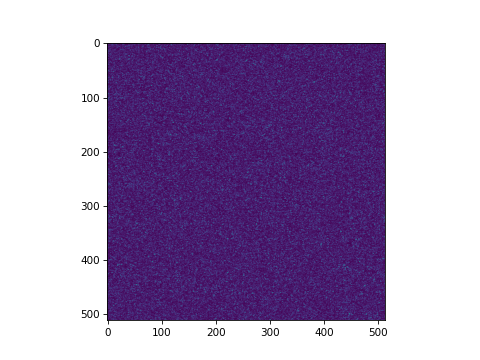

In [15]:
fig, ax = plt.subplots()

ax.imshow((np.abs(final_image_pw) ** 2)/np.max(np.abs(final_image_pw) ** 2), label='Diffraction Monte Carlo Plane Wave')

[########################################] | 100% Completed | 565.61 ms


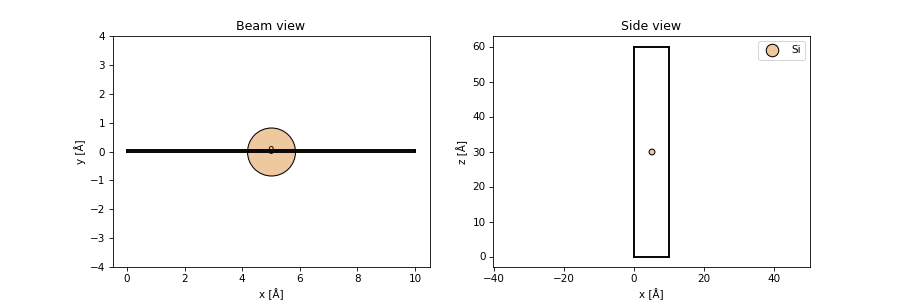

In [16]:
import ase
import numpy as np
import abtem
import matplotlib.pyplot as plt
from typing import Tuple, NamedTuple

%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}

# atoms = ase.Atoms(
#     "Si2", positions=[(1.0, 2.0, 1.0), (3.0, 2.0, 1.0)], cell=[4, 4, 2]
# )

x1 = 1.0
atom_spacing = 3.0
x2 = x1 + atom_spacing
x_centre = 5.0
x0 = x_centre - (x1) - atom_spacing/2
z = 30

atoms = ase.Atoms(
    "Si1", positions=[(x_centre, 0, z)], cell=[x_centre*2, 0.05, 60]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.05, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()




[########################################] | 100% Completed | 102.91 ms


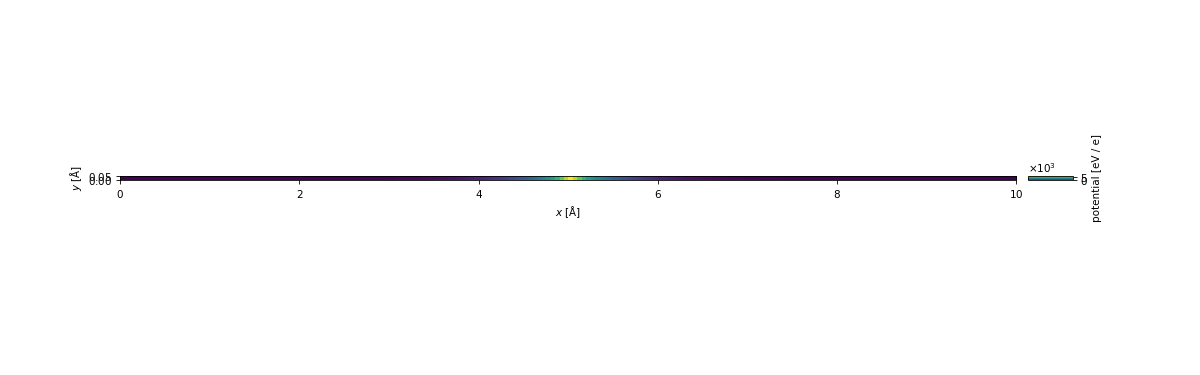

In [17]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [18]:
phi_0 = 100e3
plane_wave_abtem = abtem.PlaneWave(energy=100e3, extent=(10, 0.05), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 104.29 ms


In [19]:
from abtem.core.energy import energy2sigma, energy2wavelength

PHI_0 = 100e3

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shift = (potential_array.array * sigma).ravel()

planewaveapprox=False
num_rays=int(1e7)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_rs_aperture(num_rays, 
                                    atom_image,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z,
                                    wavelength,
                                    planewaveapprox)

planewaveapprox=True
num_rays=int(1e7)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_rs_aperture(num_rays, 
                                    atom_image_pw,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z,
                                    wavelength,
                                    planewaveapprox)

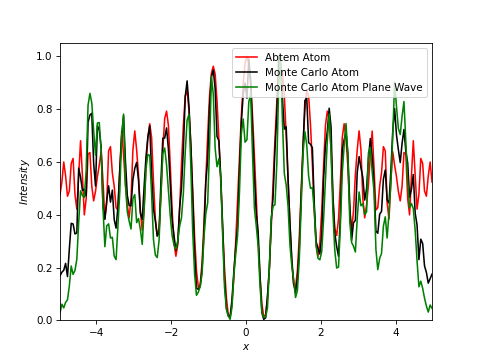

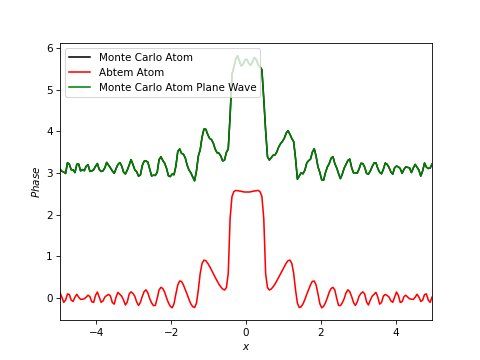

In [20]:
fig, ax = plt.subplots()
ax.plot(det_yx_coords[:, 1], np.abs(complex_image.array)**2/np.max(np.abs(complex_image.array)**2), '-r', label='Abtem Atom')
ax.plot(det_yx_coords[:, 1], np.abs(atom_image)**2/np.max(np.abs(atom_image)**2), '-k', label='Monte Carlo Atom')
ax.plot(det_yx_coords[:, 1], np.abs(atom_image_pw)**2/np.max(np.abs(atom_image_pw)**2), '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
plt.legend()

monte_carlo_phase = np.angle(atom_image_pw)
monte_carlo_phase = np.unwrap(monte_carlo_phase)

monte_carlo_phase_pw = np.angle(atom_image_pw)
monte_carlo_phase_pw = np.unwrap(monte_carlo_phase)


fig, ax = plt.subplots()
ax.plot(det_yx_coords[:, 1], monte_carlo_phase, '-k', label='Monte Carlo Atom')
ax.plot(det_yx_coords[:, 1], np.angle(complex_image.array), '-r', label='Abtem Atom')
ax.plot(det_yx_coords[:, 1], monte_carlo_phase_pw, '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
# ax.set_ylim(bottom=0)
plt.legend()

[                                        ] | 0% Completed | 1.15 ms

[########################################] | 100% Completed | 102.29 ms


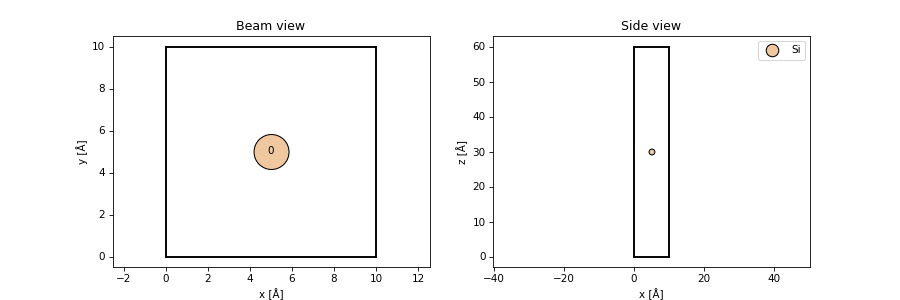

In [36]:
atoms = ase.Atoms(
    "Si1", positions=[(x_centre, x_centre, z)], cell=[x_centre*2, x_centre*2, 60]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.1, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()

[########################################] | 100% Completed | 104.16 ms


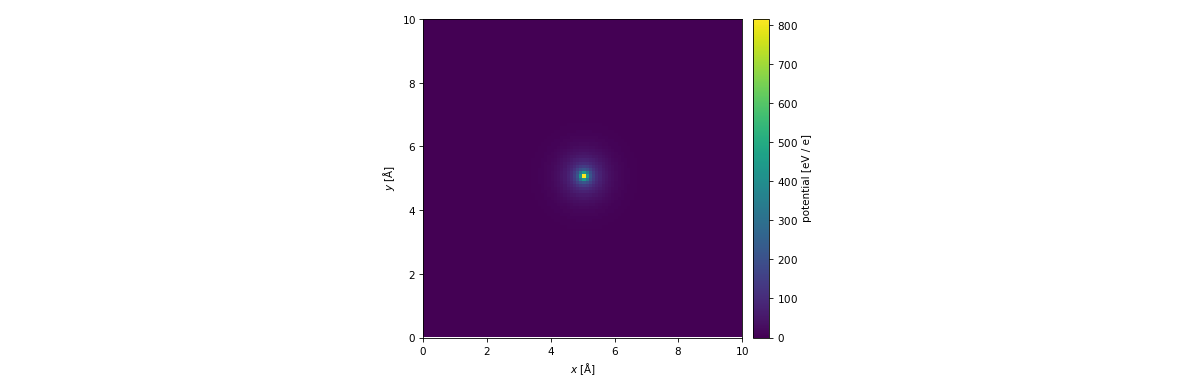

In [37]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [38]:
phi_0 = 100e3
plane_wave_abtem = abtem.PlaneWave(energy=100e3, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 104.41 ms


In [42]:
from abtem.core.energy import energy2sigma, energy2wavelength

PHI_0 = 100e3

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shift = (potential_array.array * sigma).ravel()

planewaveapprox=False
num_rays=int(1e9)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_rs_aperture(num_rays, 
                                    atom_image,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z,
                                    wavelength,
                                    planewaveapprox)

atom_image = atom_image.reshape(num_px_y, num_px_x)


In [40]:
planewaveapprox=True
num_rays=int(1e5)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_rs_aperture(num_rays, 
                                    atom_image_pw,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z,
                                    wavelength,
                                    planewaveapprox)
atom_image_pw = atom_image_pw.reshape(num_px_y, num_px_x)

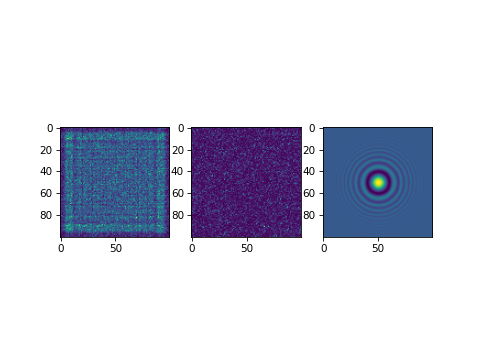

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow((np.abs(atom_image) ** 2)/np.max(np.abs(atom_image) ** 2))
ax[1].imshow((np.abs(atom_image_pw) ** 2)/np.max(np.abs(atom_image_pw) ** 2))
ax[2].imshow((np.abs(complex_image.array) ** 2)/np.max(np.abs(complex_image.array) ** 2))